<a href="https://colab.research.google.com/github/ZoloKiala/Irrigated_model/blob/main/Irrigation%20mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2024 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# !pip install pycrs
# !pip install geedim
# geemap.update_package() Uncomment to get the latest geemap

In [ ]:
# !pip install -U geemap

launch_buttons:
  colab_url: "https://colab.research.google.com"

#Proposed Workflow

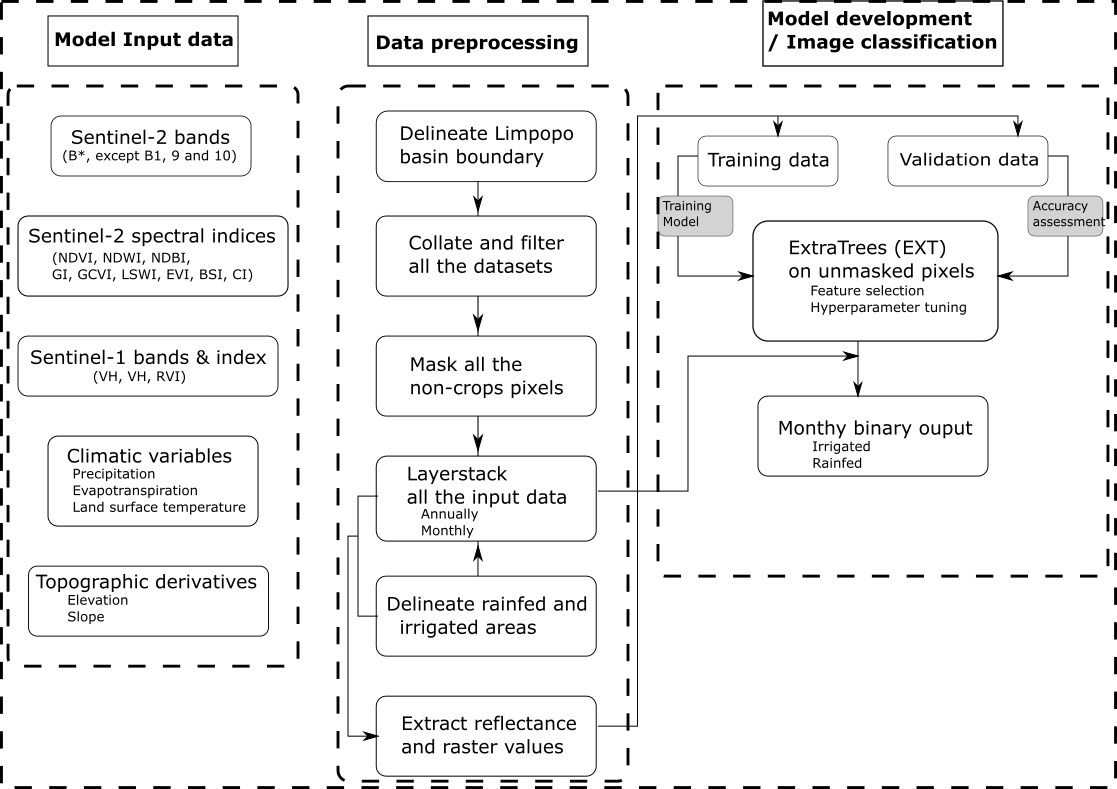

Some other processing steps were performed in GEE. Click [here](https://code.earthengine.google.com/3a5021167db90ddc1c56a9703f3bd02b) to see the script.

## Set up

In [2]:
import ee
import geopandas as gpd

import os
import geemap

from geemap import ml
from sklearn import ensemble

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from numpy import sort

import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV

import geemap.colormaps as cm
from google.colab import _frontend

from pickle import dump, load

In [3]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='tethys-app-1')

In [ ]:
# _frontend.create_scratch_cell("#@title Map\nm = geemap.Map()\nm", False)
# _frontend.create_scratch_cell("#@title Console\n", False)

In [4]:
# Select data /////
start_date = '2024-07-01'
end_date = '2024-07-30'

## Defining all the functions

In [7]:
def remapper(image):
    remapped = image.remap([1,2,4,5,7,8,9,10,11],[1,2,3,4,5,6,7,8,9])
    return remapped


def rvi(image):
    rvi = image.expression('sqrt(vv/(vv + vh))*(vv/vh)',
    {'vv': image.select('VV'),
     'vh': image.select('VH')})
    return rvi;

def mask_s2_clouds(img):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  scl = img.select('SCL')
  cloud_shadow = scl.eq(3);
  cloud_low = scl.eq(7);
  cloud_medium = scl.eq(8);
  cloud_high = scl.eq(9)

## Merging the masks together
  cloud_mask = cloud_shadow.add(cloud_low).add(cloud_medium).add(cloud_high)
  cloud_uni = cloud_mask.eq(0).selfMask()

## Finally masking the original image (or bands) with cloud mask
  cloud_masked_img = img.updateMask(cloud_uni).divide(10000)

  return cloud_masked_img


# Function for calculating vegetation indices
def vi_calculaton(image):

  """ function for calculating vegetation indices """

  NDVI = image.normalizedDifference(['B8', 'B4']).rename('NDVI') #Normalized difference vegetation index

    #Normalized difference water index
  NDWI = image.expression(
    '(GREEN - NIR)/(GREEN + NIR)', {
     'NIR': image.select('B8'),
     'GREEN': image.select('B3')
    }).rename('NDWI')

    #Normalized difference bare index
  NDBI = image.expression(
    '(SWIR - NIR)/(SWIR + NIR)', {
     'SWIR': image.select('B11'),
     'NIR': image.select('B8')
    }).rename('NDBI')

    #Green index (G.I.)
  GI = image.expression(
    '(NIR / Green)', {
     'Green': image.select('B3'),
     'NIR': image.select('B8')
    }).rename('GI')


    #Chlorophyll index (CI)
  CI = image.expression(
    '(NIR / RedEdge) - 1', {
     'NIR': image.select('B8'),
     'RedEdge': image.select('B5')
    }).rename('CI')

    #Green chlorophyll vegetation index (GCVI)
  GCVI = image.expression(
    'NIR / Green - 1', {
     'Green': image.select('B3'),
     'NIR': image.select('B8')
    }).rename('GCVI')

    #Land surface water index (LSWI)
  LSWI = image.expression(
    '(NIR - SWIR)/(NIR + SWIR)', {
     'SWIR': image.select('B11'),
     'NIR': image.select('B8')
    }).rename('LSWI')

    #Enhanced vegetation index (EVI)
  EVI = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
      'NIR': image.select('B8'),
      'RED': image.select('B4'),
      'BLUE': image.select('B2')
        }).toFloat().rename('EVI')

    # Bare soil index (BSI)
  BSI = image.expression(
    '(SWIR + Red) - (NIR + Blue) / (SWIR + Red) + (NIR + Blue)', {
      'NIR': image.select('B8'),
      'SWIR': image.select('B11'),
      'Red': image.select('B4'),
      'Blue': image.select('B2')
        }).toFloat().rename('BSI')

  return image.addBands([NDVI, NDWI, NDBI, GI, GCVI, LSWI, EVI, BSI, CI])


def normalize(image):

  """ function for normalizing images """

  bandNames = image.bandNames()

    #/ Compute min and max of the image
  minDict =  image.reduceRegion(**{
      'reducer' : ee.Reducer.min(),
      'geometry' : AOI_1,
      'scale' : 10,
      "maxPixels" : 1e9,
      'bestEffort' : True,
      "tileScale" : 16
    })

  maxDict =  image.reduceRegion(**{
    'reducer' : ee.Reducer.max(),
    'geometry' : AOI_1,
    'scale' : 10,
    'maxPixels' : 1e9,
    'bestEffort' : True,
    'tileScale' : 16
    })

  mins = ee.Image.constant(minDict.values(bandNames))
  maxs = ee.Image.constant(maxDict.values(bandNames))

  normalized =  image.subtract(mins).divide(maxs.subtract(mins))

  return normalized


# Image classification

## Preparing the data

In [8]:
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}

# Import study area footprint
AOI_1 = ee.FeatureCollection('projects/ee-zolokialall/assets/Lim_Basin')

# Import training samples (irrigated and rainfed)
#training_pts = ee.FeatureCollection('projects/ee-zolokialall/assets/2021-06-01_training') # Training samples extracted from SA land cover (2020)


# Mask
mask = ee.FeatureCollection('projects/ee-zolokialall/assets/mask_brief')
# irrigated_class = training_pts.filter(ee.Filter.eq('land_cover', 1))
# rainfed_class = training_pts.filter(ee.Filter.eq('land_cover', 2))

band_to_sel = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8','B8A', 'B11', 'B12', 'SCL']
######################################################### Sentinel-2 ####################################
S2img = ee.ImageCollection("COPERNICUS/S2") \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)).filterBounds(AOI_1).filterDate(start_date, end_date).map(mask_s2_clouds).median().select(band_to_sel) # updateMsk instead of clip

# Calculate Vegetation indices
#NDVI, NDWI, NDBI,G.I.,GCVI,LSWI, EVI, BSI, Terrain elevation,Terrain slope (still more to be added)

S2_vi = vi_calculaton(S2img)

# S2_vi_norm = normalize(S2_vi). This didn't work. I will look at it later

######################################################### End of Sentinel-2 ####################################


######################################################### Sentinel-1 ####################################
S1img = ee.ImageCollection('COPERNICUS/S1_GRD') \
                      .filterDate(start_date, end_date).filterBounds(AOI_1) \
                      .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
                      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                      ##.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# Calculate temporal means for various observations to use for visualization.
vh = S1img.select('VH').mean();
vv = S1img.select('VV').mean();

rvi = S1img.map(algorithm=rvi).mean()


S1Img = ee.ImageCollection.fromImages([vh, vv, rvi]).toBands();

######################################################### End of Sentinel-1 ####################################

######################################################### Combine all the variables ####################################
all_variables = ee.ImageCollection.fromImages([S2_vi, S1Img]).toBands()
all_variables_clip = all_variables.clip(mask)

band_names = all_variables_clip.bandNames()  # Get the list of variables before
display(band_names)

img_for_classification = all_variables_clip.select(['0_B2', '0_B3', '0_B4', '0_B5', '0_B6', '0_B7', '0_B8', '0_B8A', '0_B11', '0_B12',
                                       '0_NDVI', '0_NDWI', '0_NDBI', '0_GI', '0_GCVI', '0_LSWI', '0_EVI', '0_BSI','0_CI',
                                      '1_0_VH', '1_1_VV', '1_2_VV']).rename('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12',
                                       'NDVI', 'NDWI', 'NDBI', 'GI', 'GCVI', 'LSWI', 'EVI', 'BSI', 'CI',
                                      'VH', 'VV', 'RVI')   #rename bands in the composite image


band_names = img_for_classification.bandNames()  # Get the list of variables after ###################################
display(band_names)

/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


## Training sample generation.
Use this link to generate training samples: [Generating training samples](https://code.earthengine.google.com/45953f316884cca9909f5abc181d29ac)

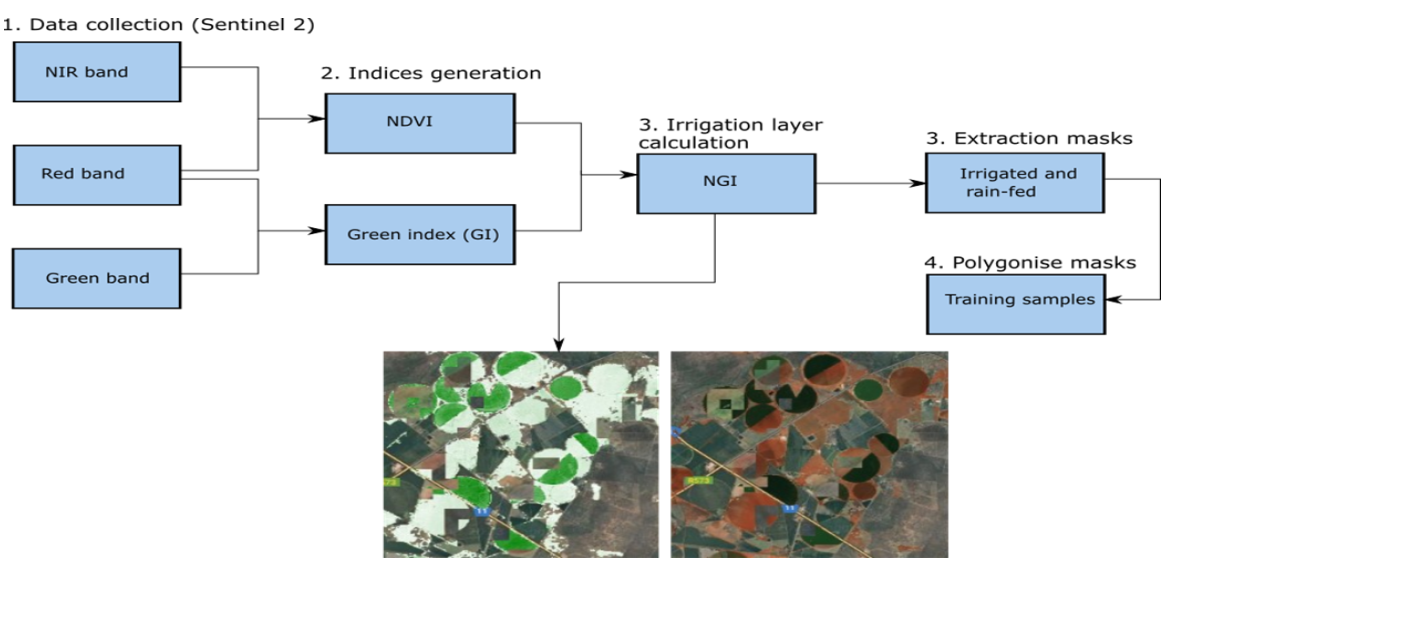

In [ ]:
img_date = start_date[:7]
training = ee.FeatureCollection('projects/ee-zolokialall/assets/' + img_date + '_training_GEE_poly_uns_f')
print(img_date)

# training = training.filter(ee.Filter.eq('class', 1)).limit(15).merge(training.filter(ee.Filter.eq('class', 2)).limit(15))
training = training.filter(ee.Filter.eq('class', 1)).limit(**{'maximum': 10, 'opt_property': 'count', 'opt_ascending': True}).merge(training.filter(ee.Filter.eq('class', 2)).limit(**{'maximum': 10, 'opt_property': 'count', 'opt_ascending': True}))

2024-07


In [ ]:
# Visualisation different layers
vizParams = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.5,
 ## 'gamma': [0.95, 1.1, 1]
}

m = geemap.Map()

m.centerObject(AOI_1, 8)

m.addLayer(img_for_classification, vizParams, 'Image for classification')

m.addLayer(mask, {}, 'Mask') ### add the esa global_cropland mask to the map

# #Map.addLayer(global_cropland_lc2020_dw,  {}, 'global_cropland_lc2020_dw') ### add the Dynamic World global_cropland mask to the map

m.addLayer(AOI_1, {}, 'Limpop River basin') ### add the study area footprint to the map

m.add_basemap('HYBRID')

m.addLayer(training.filter(ee.Filter.eq('class', 2)), {}, 'Training_rain_fed')
m.addLayer(training, {}, 'Training_irrigated')

m


Map(center=[-23.357652402774438, 29.593179096641578], controls=(WidgetControl(options=['position', 'transparen…

## Model development

#### Image classification

In [ ]:
# Use these bands for prediction.
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12',
                                       'NDVI', 'NDWI', 'NDBI', 'GI', 'GCVI', 'LSWI', 'EVI', 'BSI', 'CI',
                                     ]

# This property of the table stores the land cover labels.
label = 'class'

# Overlay the points on the imagery to get training.
training_sample = img_for_classification.select(bands).sampleRegions(
    **{'collection': training, 'properties': [label], 'scale': 30}
)

# print('Number of features', training_sample.size().getInfo()); #print out the number of records

############################################### The code below will fail because the image is too big. We need to extract the raster values at locations of training samples. Umcomment the code below ######
# Adds a column of deterministic pseudorandom numbers.
sample = training_sample.randomColumn()

split = 0.7

training = sample.filter(ee.Filter.lt('random', split))
validation = sample.filter(ee.Filter.gte('random', split))


# Train a RF classifier with default parameters.
# trained = ee.Classifier.smileCart().train(training, label, variables)

classifier = ee.Classifier.smileRandomForest(100).train(training, label, bands)

# Classify the image with the same bands used for training.
result = img_for_classification.select(bands).classify(classifier).clip(mask)   #Anual maps


### DEM
glo30 = ee.ImageCollection("projects/sat-io/open-datasets/GLO-30");

dem = glo30.mosaic().setDefaultProjection('EPSG:3857', None,30)

##Elevation
dem_clip = dem.clip(mask)  ###Clip the dem to AOI

##Slope
slope = ee.Terrain.slope(dem_clip);
slopeTresh = slope.gte(5)
slopeMask = slopeTresh.selfMask();

result1 = result.updateMask(slopeMask.unmask().Not())

In [ ]:
#comment the code below. It will generate a timeout error

palette = [ '#FF0000', '#008000']  ## #FF0000: red (rainfaid); #008000: green (irrigated)

# # Display the clusters with random colors.
m.addLayer(result, {"min": 1, "max": 2, "palette": palette}, 'classified (basic)')
m.addLayer(result1, {"min": 1, "max": 2, "palette": palette}, 'classified (basic)1')

legend_dict = {
    "Irrigated": "#008000",
    "Rainfed": "#FF0000",
}

m.add_legend(
    title='Classification legend', legend_dict=legend_dict, draggable=False
)


m.addLayer(training.filter(ee.Filter.eq('class', 1)), {'color':'#FF0000'}, 'Irrigated_poly') ### add training samples to the map
m.addLayer(training.filter(ee.Filter.eq('class', 2)), {'color':'#008000'}, 'Rainfed_poly') ### add training samples to the map


In [ ]:
#Export the predicted map (a GEE asset folder)
task = ee.batch.Export.image.toAsset(
    image= result1.select('classification').eq(2).clip(mask).selfMask(),
    description= img_date + '_final_f',
    assetId='users/zolokiala1/' + img_date + '_final_f',  # <> modify these
    scale=30,
    maxPixels= 10000000000000
)
task.start()

#### Accuracy assessment

In [ ]:
# #comment the code below. It will generate a timeout error

# validated = validation.classify(classifier)

# test_accuracy = validated.errorMatrix('land_cover', 'classification')  #Overal accuracy

# print('overall accuracy')
# test_accuracy.accuracy().getInfo()

# test_accuracy.producersAccuracy().getInfo()

# test_accuracy.consumersAccuracy().getInfo()

In [ ]:
# print('Kappa coefficient')
# test_accuracy.kappa().getInfo()

#### Filtering classified map

In [ ]:
result_clean = result.reduceNeighborhood(
  reducer = ee.Reducer.mode(),
  kernel =  ee.Kernel.circle(1)
  )

result_clean = result_clean.updateMask(slopeMask.unmask().Not())


m.addLayer(result_clean, {"min": 1, "max": 2, "palette": palette}, 'classified_clean')

In [ ]:
#Export the filtered classified map (a GEE asset folder)
task = ee.batch.Export.image.toAsset(
    image= result_clean.select('classification_mode').eq(2).clip(mask).selfMask(),
    description= img_date + '_filtered_final',
    assetId='users/zolokiala1/' + img_date + 'filtered_final',  # <> modify these
    scale=30,
    maxPixels= 10000000000000
)
task.start()

#### Creating probability Map

In [ ]:
## rename class unique values
img_date = start_date[:7]
training = ee.FeatureCollection('projects/ee-zolokialall/assets/' + img_date + '_training_GEE_poly_uns')
print(img_date)

# training = training.filter(ee.Filter.eq('class', 1)).limit(15).merge(training.filter(ee.Filter.eq('class', 2)).limit(15))
training = training.filter(ee.Filter.eq('class', 1)).limit(**{'maximum': 10, 'opt_property': 'count', 'opt_ascending': True}).merge(training.filter(ee.Filter.eq('class', 2)).limit(**{'maximum': 10, 'opt_property': 'count', 'opt_ascending': True}))

In [ ]:
# change values of classes
rainfedClassTraining = training.filter(ee.Filter.eq('class', 1))
irrigatedClassTraining = training.filter(ee.Filter.eq('class', 2))

training_new = (
    rainfedClassTraining
    # Convert 'areasqkm' property from string to number.
    .map(
        lambda feature: feature.set(
            'class', int(0))
        )
    ).merge(
    irrigatedClassTraining
    # Convert 'areasqkm' property from string to number.
    .map(
        lambda feature: feature.set(
            'class', int(1))
        )
    )

rainfedClassTraining_new = training_new.filter(ee.Filter.eq('class', 0))
irrigatedClassTraining_new = training_new.filter(ee.Filter.eq('class', 1))


# m.addLayer(rainfedClassTraining_new, {'color':'#FF0000'}, 'Irrigated_poly_prob') ### add training samples to the map
# m.addLayer(irrigatedClassTraining_new, {'color':'#008000'}, 'Rainfed_poly_prob') ### add training samples to the map
m.addLayer(training_new, {'color':'#008000'}, 'Rainfed_poly_prob') ### add training samples to the map

m

In [ ]:
#Model development

#Use these bands for prediction.
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'NDWI', 'NDBI', 'GI', 'GCVI', 'LSWI', 'EVI', 'BSI', 'CI']

# This property of the table stores the land cover labels.
label = 'class'

# Overlay the points on the imagery to get training.
training_sample = img_for_classification.select(bands).sampleRegions(
    **{'collection': training_new, 'properties': [label], 'scale': 30}
)

# print('Number of features', training_sample.size().getInfo()); #print out the number of records

############################################### The code below will fail because the image is too big. We need to extract the raster values at locations of training samples. Umcomment the code below ######
# Adds a column of deterministic pseudorandom numbers.
sample = training_sample.randomColumn()

split = 0.7

training = sample.filter(ee.Filter.lt('random', split))
validation = sample.filter(ee.Filter.gte('random', split))

# Use these bands for prediction.
#bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'NDWI', 'NDBI', 'GI', 'GCVI', 'LSWI', 'EVI', 'BSI', 'CI', 'VH', 'VV','RVI']

# This property of the table stores the land cover labels.
label = 'class'

training = sample.filter(ee.Filter.lt('random', split))
validation = sample.filter(ee.Filter.gte('random', split))


# Train a RF classifier with default parameters.
# trained = ee.Classifier.smileCart().train(training, label, variables)

classifier = ee.Classifier.smileRandomForest(100).train(training, label, bands).setOutputMode("PROBABILITY")

# Classify the image with the same bands used for training.
result_prob = img_for_classification.select(bands).classify(classifier).updateMask(slopeMask.unmask().Not()) ## Remove also the slope

palette = ['a50026','d73027','f46d43','fdae61','fee08b','ffffbf','d9ef8b','a6d96a','66bd63','1a9850','006837',]

# # Display the clusters with random colors.
m.addLayer(result_prob, {"min": 0, "max": 1, "palette": palette}, 'classified (probability)')
m


In [ ]:
### Export probability map (a GEE asset folder)

task = ee.batch.Export.image.toAsset(
    image= result_prob.select('classification'),
    description= img_date + '_prob_final',
    assetId='users/zolokiala1/' + img_date + '_prob_final',  # <> modify these
    scale=30,
    maxPixels= 10000000000000
)
task.start()

## Futher cleaning of classified map: [Click here](https://code.earthengine.google.com/1865ccb6df1db2a79cf26d4d9bb7db7b)